In [24]:
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import sqlite3

plt.rcParams["font.family"] = "Helvetica Neue"

db = sqlite3.connect("./scores.db")

with open("data/output.csv", "rb") as f:
    data = pd.read_csv(f, delimiter="\t")

<Axes: title={'center': '# of scores per session over time'}>

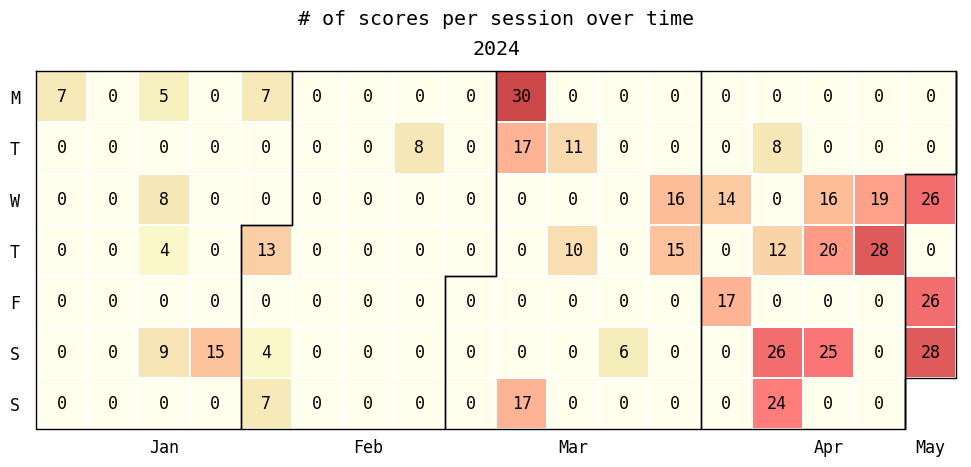

In [25]:
from datetime import date, datetime
import july
from july.utils import date_range
from utils import CST
c = db.cursor()
result = c.execute("""
    SELECT COUNT(*), UNIXEPOCH(DATE(scores."Time Played")) as date FROM scores
    GROUP BY date
""")
result = list(result)
result.sort(key=lambda x: x[1])
y, x = list(zip(*result))
dates = list(map(lambda x: datetime.utcfromtimestamp(x).astimezone(tz=None), x))
# dates = matplotlib.dates.date2num(x)
# plt.title("Amount of maps played per session over time")
# plt.xticks(rotation=45, ha="right")
# plt.plot(dates, y)
# plt.gcf().autofmt_xdate()
# plt.show()
july.heatmap(dates, y, title='# of scores per session over time',
    # cmap='Pastel1',
    # date_label=True,
    value_label=True,
    month_grid=True,
)

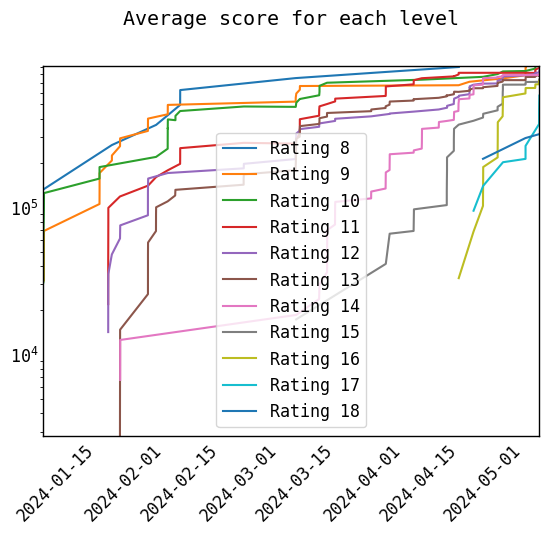

In [26]:
from statistics import mean
from datetime import datetime
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.axis import YAxis


c = db.cursor()
ratings = list(map(lambda r: r[0], c.execute("select distinct Rating from scores")))
ratings.sort()

for rating in ratings:
    result = c.execute('select "Song ID", UNIXEPOCH("Time Played"), "Song Name", Score from scores where Rating = ? order by "Time Played"', (rating,))
    result = list(result)
    scores = dict()
    xs = []
    ys = []
    for record in result:
        song_id = record[0]
        scores[song_id] = 0
    for record in result:
        song_id, time_played, song_name, score = record
        date = datetime.utcfromtimestamp(time_played)
        scores[song_id] = score
        values = list(scores.values())
        avg = mean(values)
        xs.append(date)
        ys.append(avg)

    if xs and ys:
        plt.plot(xs, ys, label=f"Rating {rating}")

plt.legend()
plt.xticks(rotation=45, ha="right")
plt.yscale('log')
plt.title("Average score for each level")
plt.show()

In [27]:
JST = pytz.timezone("Asia/Tokyo")
CST = pytz.timezone("America/Chicago")

def to_jst_timestamp(s: str, format_str="%Y-%m-%d %H:%M:%S"):
    if type(s) is not str: return None
    naive_dt = datetime.strptime(s, format_str)
    jst_dt = JST.localize(naive_dt)
    cst_dt = jst_dt.astimezone(CST)
    return cst_dt

times = data["Time Played"]
times_mapped = times.map(to_jst_timestamp)
days_played = times_mapped.groupby(times_mapped.dt.date).count()
result = days_played.sort_values(ascending=False).head(10)
display(Markdown(result.to_markdown()))

Time Played
2024-03-04    29
2024-05-04    28
2024-04-14    24
2024-05-03    24
2024-05-01    23
2024-04-13    22
2024-04-18    20
2024-04-25    20
2024-04-20    18
2024-03-10    17
Name: Time Played, dtype: int64


In [28]:
records_by_level = data.loc[data["Lamp"] != "Fail"].groupby(data["Rating"])
num_clears_by_level = records_by_level["Score"].count().rename("Clears")
average_scores_by_level = records_by_level["Score"].mean().round().astype("int").rename("Average")
def max_info(group):
    max_idx = group["Score"].idxmax()
    min_idx = group["Score"].idxmin()
    max_score = group.loc[max_idx][["Score", "Lamp", "Song Name"]].rename({ "Score": "Max Score", "Lamp": "Max Score Lamp", "Song Name": "Max Score Song" })
    min_score = group.loc[min_idx][["Score", "Lamp", "Song Name"]].rename({ "Score": "Min Score", "Lamp": "Min Score Lamp", "Song Name": "Min Score Song" })
    return pd.concat([max_score, min_score])
max_score_by_level = records_by_level.apply(max_info)
result = pd.merge(num_clears_by_level, average_scores_by_level, on="Rating")
result = pd.merge(result, max_score_by_level, on="Rating")
with pd.option_context('expand_frame_repr', False):
    display(Markdown(result.to_markdown()))

|   Rating |   Clears |   Average |   Max Score | Max Score Lamp   | Max Score Song     |   Min Score | Min Score Lamp   | Min Score Song                         |
|---------:|---------:|----------:|------------:|:-----------------|:-------------------|------------:|:-----------------|:---------------------------------------|
|        8 |        7 |    895073 |      996620 | GFC              | 朧 (dj TAKA Remix) |      685090 | Clear            | RED ZONE                               |
|        9 |       25 |    918551 |      999650 | PFC              | Why not            |      730730 | Clear            | Clarity                                |
|       10 |       31 |    924433 |      992160 | GFC              | 隅田川夏恋歌       |      779880 | Clear            | 初音ミクの消失                         |
|       11 |       44 |    899018 |      992520 | GFC              | 朧                 |      728300 | Clear            | Bad Apple!! feat. nomico               |
|       12 |       62 |    897328 |      987030 | GFC              | MY SUMMER LOVE     |      765380 | Clear            | Life is beautiful                      |
|       13 |       74 |    843144 |      978430 | GFC              | Struggle           |      619400 | Clear            | ラキラキ                               |
|       14 |      125 |    801284 |      960440 | FC               | FUNKY SUMMER BEACH |      666000 | Clear            | Pluto The First                        |
|       15 |       27 |    802587 |      917120 | Clear            | Toy Box Factory    |      684060 | Clear            | ENDYMION                               |
|       16 |       19 |    779613 |      862810 | Clear            | Life is beautiful  |      691570 | Clear            | PRANA                                  |
|       17 |        3 |    724233 |      765430 | Clear            | Elemental Creation |      662870 | Clear            | PRANA+REVOLUTIONARY ADDICT (U1 DJ Mix) |

In [29]:
# Gold 1
gold1scores = []
gold1scores.append(data[(data["Score"] >= 975000) & (data["Rating"] == 13)].head(1))
gold1scores.append(data[(data["Score"] >= 925000) & (data["Rating"] == 14)].head(1))
gold1scores.append(data[(data["Score"] >= 875000) & (data["Rating"] == 15)].head(1))
gold1scores.append(data[(data["Score"] >= 825000) & (data["Rating"] == 16)].head(1))
gold1scores.append(data[(data["Score"] >= 750000) & (data["Rating"] == 17)].head(1))
with pd.option_context('expand_frame_repr', False):
    gold1scores = pd.concat(gold1scores)
    display(Markdown(gold1scores.to_markdown()))

|     | Song ID                          | Song Name          | Difficulty   |   Rating |   Score | Grade   | Lamp   | Time Uploaded       | Time Played         |
|----:|:---------------------------------|:-------------------|:-------------|---------:|--------:|:--------|:-------|:--------------------|:--------------------|
|  44 | 1idIoi66ll806D8ddldOQi8bdiDO0Oil | Struggle           | ESP          |       13 |  978430 | AA+     | GFC    | 2024-04-18 18:14:49 | 2024-04-18 18:05:47 |
| 128 | 9i6dOd608qb0IlqoDIPb8q1o8q1ddQQd | FUNKY SUMMER BEACH | ESP          |       14 |  960440 | AA+     | FC     | 2024-05-05 05:34:41 | 2024-05-05 05:22:53 |
|  59 | 1qPIiqqQo0P9dD90I11q90b0ooIidbPO | CyberConnect       | ESP          |       15 |  903280 | AA      | Clear  | 2024-05-05 02:40:07 | 2024-05-05 02:32:47 |
| 112 | 90lolio9qd6qo6Pl8oo69iqi81oiiQib | I'm so Happy       | CSP          |       16 |  839540 | A       | Clear  | 2024-05-05 02:19:22 | 2024-05-05 02:14:35 |
| 347 | OiIOPd80d9PQQIbidO6ObioboO88OD9l | Elemental Creation | ESP          |       17 |  765430 | B+      | Clear  | 2024-05-05 05:34:41 | 2024-05-05 05:12:27 |